# Uncertainty assessment

The IPCC guidelines provide information on taking into acount uncertainty.
The ippc package implements those by allowing the user to do analytical error propagation and Monte Carlo simualtion when running a tier sequence. 

To use one of the approaches, each parameter involved in a sequence requires information about its uncertainty. This information is specifeid by the properties "def" , "min", "max", "abs_min" and "abs_max" (mean, 2.5 percentile, 97.5 percentile, absolute minimum, absolute maximum) in the parameter table.

Let´s use the from Worldbank on urban population...

In [1]:
import pandas as pd
import numpy as np


df = pd.read_csv("URB_TOTL_Worldbank_DE.csv", skiprows=4).drop(columns=["Unnamed: 67"])
df = df.set_index("Country Name")

ALL = df.drop(columns=[ "Country Code", "Indicator Name", "Indicator Code"]).transpose()
DE = ALL["Germany"]
DE.index.name="year"
DE.name="urb_population"

# create the parameter table

DE_df = pd.DataFrame({})

DE_df["value"] = DE.values
DE_df["year"] = [int(i) for i in DE.index]
DE_df["region"] ="DE"
DE_df["property"] ="def"
DE_df["unit"] ="cap"
DE_df.set_index(["year", "region", "property"],inplace=True)
DE_df.head(5)

value unit
year region property               
1960 DE     def       51978188  cap
1961 DE     def       52609561  cap
1962 DE     def       53122383  cap
1963 DE     def       53664331  cap
1964 DE     def       54147106  cap

... and uncertainty information.
According to volume 5 (waste), chapter 6 (wastewater), the uncertainty range for population can be estimated with +- 5%.

In [2]:
# modify the dataframe
df_min = DE_df.copy()
df_max = DE_df.copy()
df_abs_min = DE_df.copy()
df_abs_max = DE_df.copy()

df_min.index = df_min.index.set_levels(df_min.index.levels[2].str.replace('def', 'min'), level=2)
df_max.index = df_max.index.set_levels(df_max.index.levels[2].str.replace('def', 'max'), level=2)
df_abs_min.index = df_abs_min.index.set_levels(df_abs_min.index.levels[2].str.replace('def', 'abs_min'), level=2)
df_abs_max.index = df_abs_max.index.set_levels(df_abs_max.index.levels[2].str.replace('def', 'abs_max'), level=2)

df_min["value"]=df_min["value"]*0.95
df_max["value"]=df_max["value"]*1.05
df_abs_min["value"]=df_abs_min["value"]*0
df_abs_max["value"]=df_abs_max["value"]*np.inf
df_abs_max.head()

value unit
year region property            
1960 DE     abs_max     inf  cap
1961 DE     abs_max     inf  cap
1962 DE     abs_max     inf  cap
1963 DE     abs_max     inf  cap
1964 DE     abs_max     inf  cap

## Add the parameter table and run the sequence

### First, with Monte Carlo simulation

In [3]:
from ipcc import IPCC

test = IPCC()

# add the data for parameter urb_population
df=pd.concat([DE_df,df_max,df_min,df_abs_max,df_abs_min])
test.waste.incineration.parameter.urb_population=df

# run the sequence
sequence = test.waste.incineration.sequence.tier1_co2(year=2010, region="DE", wastetype= "msw_paper", incintype= "inc_unspecified", uncertainty="monte_carlo")
s = sequence.__dict__


2023-10-26 21:12:39,000 - INFO - Incineration sequence started --->
2023-10-26 21:12:39,001 - INFO - Uncertainty distribution for parameter 'urb_population':
2023-10-26 21:12:39,001 - INFO - lognormal distribution
2023-10-26 21:12:39,002 - INFO - Uncertainty distribution for parameter 'msw_gen_rate':
2023-10-26 21:12:39,002 - INFO - lognormal distribution
2023-10-26 21:12:39,002 - INFO - Uncertainty distribution for parameter 'msw_frac_to_incin':
2023-10-26 21:12:39,003 - INFO - normal distribution, lower uncertainty
2023-10-26 21:12:39,003 - INFO - Uncertainty distribution for parameter 'msw_type_frac':
2023-10-26 21:12:39,004 - INFO - normal distribution, lower uncertainty
/Users/TN76JP/Documents/coderefinery/ipcc/ipcc/src/ipcc/_sequence.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_c = c

In [4]:
# check the first step (signature)
s["signature"]

{'year': 2010,
 'region': 'DE',
 'wastetype': 'msw_paper',
 'incintype': 'inc_unspecified',
 'uncertainty': 'monte_carlo'}

In [5]:
# check the last step (emissions)
type(s["co2_emissions"].value)

numpy.ndarray

(array([232., 311., 257., 124.,  49.,  17.,   9.,   0.,   0.,   1.]),
 array([8.31806117e-04, 3.80437260e+01, 7.60866202e+01, 1.14129514e+02,
        1.52172409e+02, 1.90215303e+02, 2.28258197e+02, 2.66301091e+02,
        3.04343985e+02, 3.42386879e+02, 3.80429774e+02]),
 <BarContainer object of 10 artists>)

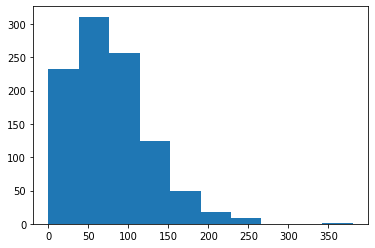

In [6]:
# plot the emissions
import matplotlib.pyplot as plt

plt.hist(sequence.co2_emissions.value)

### Compare with analytical error propagation

In [7]:
final_step = test.waste.incineration.sequence.tier1_co2(year=2010, region="DE", wastetype= "msw_paper", incintype= "inc_unspecified", uncertainty="analytical").co2_emissions
final_step

2023-10-26 21:12:39,386 - INFO - Incineration sequence started --->
/Users/TN76JP/Documents/coderefinery/ipcc/ipcc/src/ipcc/_sequence.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_c = conc_df.loc[c][j]
2023-10-26 21:12:39,388 - INFO - 'Region DE' has been replaced by 'World' during reading parameter table 'incintype_frac'
2023-10-26 21:12:39,389 - INFO - 'Region DE' has been replaced by 'World' during reading parameter table 'dm'
2023-10-26 21:12:39,390 - INFO - 'Region DE' has been replaced by 'World' during reading parameter table 'cf'
2023-10-26 21:12:39,391 - INFO - 'Region DE' has been replaced by 'World' during reading parameter table 'fcf'
2023-10-26 21:12:39,391 - INFO - 'Region DE' has been replaced by 'World' during reading parameter table 'of'
2023-10-26 21:12:39,392 - INFO - ---

Step(position=12, year=2010, unit='Gg/year', value=83.21875307457027+/-49.5585492307953, type='elementary')

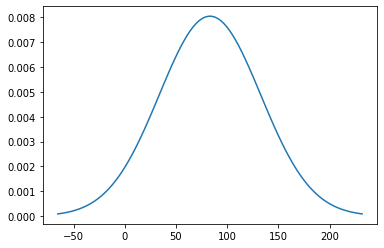

In [8]:
import scipy.stats as stats

mu = final_step.value.n
sigma = final_step.value.std_dev
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

## What can we learn?

In this example, the values can be negative when using analytical error propagation. This is due to the high uncertainties in the data, using the tier 1 approach. However, it does not make sense to have negative CO2 emissions! Thus, Monte Carlo simulation should be used as a proper technique for uncertainty analysis.